In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import ToTensor,Resize

from PIL import Image
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import time
import sys
import csv
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import torch.nn.functional as func

from sklearn.metrics.ranking import roc_auc_score
import sklearn.metrics as metrics
import random

use_gpu = torch.cuda.is_available()

In [2]:
#Utility functions for cleaning the data

def cleanLabel(x):
    
    labelCount = 0    
    if x.Pleural_Effusion == 1:
        labelCount += 1
    if x.Edema == 1:
        labelCount += 1
    if x.Cardiomegaly ==1:
        labelCount += 1
    if x.Pneumonia == 1:
        labelCount += 1
    return labelCount
    
    

def getLabel(x):
    
    if x.Pleural_Effusion ==1:
        return "Pleural_Effusion"
    elif x.Edema == 1:
        return "Edema"
    elif x.Cardiomegaly==1:
        return "Cardiomegaly"
    elif x.Pneumonia == 1:
        return "Pneumonia"
    else:
        return "0"

In [3]:
cols = ['Path',
 'Sex',
 'Age',
 'View',
 'AP/PA',
 'No_Finding',
 'Enlarged_Cardiomediastinum',
 'Cardiomegaly',
 'Lung_Opacity',
 'Lung_Lesion',
 'Edema',
 'Consolidation',
 'Pneumonia',
 'Atelectasis',
 'Pneumothorax',
 'Pleural_Effusion',
 'Pleural_Other',
 'Fracture',
 'Support_Devices']

In [4]:
!ls

CheXpert-v1.0-small           densenet_lateral.pt
LRWithReplacement.ipynb       logs
LRWithReplacement4Class.ipynb modProject.ipynb
Project.ipynb                 train
ROC1345.png                   train.csv
TestModels.ipynb              valid
cnn_14_10epchs.pt             valid.csv
densenet_5epochs.pt           validNew2.csv
densenet_frontal.pt           vatsal.py


In [5]:
labelMap = {"Pleural_Effusion":0, "Edema":1,"Cardiomegaly":2,"Pneumonia":3}

def getLabelDf(x):
    x = x[36:]          #To account for the extra "././" added before the Path variable
    x = df.loc[df.Path == x] 
    return labelMap[x.label.values[0]]

In [6]:
class LungDataset(Dataset):
    

    def __init__(self, csvFile, rootDir, transform = None):
        """
        Args:
            rootDir : Directory that has train, valid, train.csv and valid.csv
            csvFile : train.csv or valid.csv
        """
        
        self.rootDir = rootDir
        self.transform = transform
        
        cols = ['Path',
                 'Sex',
                 'Age',
                 'View',
                 'AP/PA',
                 'No_Finding',
                 'Enlarged_Cardiomediastinum',
                 'Cardiomegaly',
                 'Lung_Opacity',
                 'Lung_Lesion',
                 'Edema',
                 'Consolidation',
                 'Pneumonia',
                 'Atelectasis',
                 'Pneumothorax',
                 'Pleural_Effusion',
                 'Pleural_Other',
                 'Fracture',
                 'Support_Devices']
        
        self.df = pd.read_csv(os.path.join(rootDir,csvFile), names = cols, header=0)
        
        
        #Modifying the path variable
        self.df["Path"] = self.df.Path.apply(lambda x : x.replace('CheXpert-v1.0-small',"")[1:])
        
        #retaining important vars
        selectCols = ['Path',"View",'Sex',"Pleural_Effusion", "Edema","Cardiomegaly","Pneumonia"]
        self.df = self.df[selectCols]
        
        self.df['isClean'] = self.df.apply(lambda x : cleanLabel(x), axis = 1)

        #Retaining only samples with 1 disease
        self.df = self.df[self.df.isClean==1]
        
        #Creating the label variable
        self.df['label'] = self.df.apply(lambda x : labelMap[getLabel(x)], axis = 1)
                



    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        imgPath = os.path.join( self.rootDir, self.df.iloc[idx].Path)
        image = Image.open(imgPath).convert('RGB')
        
        label = self.df.iloc[idx].label

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
baseFolder = "./"
trainDataset = LungDataset('train.csv', baseFolder, transforms.Compose([Resize((256,256)), ToTensor()]))
validationDataset = LungDataset('valid.csv', baseFolder, transforms.Compose([Resize((256,256)), ToTensor()]))

In [8]:
e = next(iter(trainDataset))
e[0].size()

torch.Size([3, 256, 256])

In [9]:
train_data_loader = DataLoader(trainDataset, batch_size= 32, shuffle = True, num_workers = 4)
validation_loader = DataLoader(validationDataset, batch_size= 32, shuffle = True, num_workers = 4)

In [10]:
LOG_DIR = './logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

!if [ -f ngrok ] ; then echo "Ngrok already installed" ; else wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip > /dev/null 2>&1 && unzip ngrok-stable-linux-amd64.zip > /dev/null 2>&1 ; fi

In [11]:
get_ipython().system_raw('./ngrok http 6006 &')

In [12]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print('Tensorboard Link: ' +str(json.load(sys.stdin)['tunnels'][0]['public_url']))"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/CraigFan/anaconda3/lib/python3.6/json/__init__.py", line 299, in load
    parse_constant=parse_constant, object_pairs_hook=object_pairs_hook, **kw)
  File "/Users/CraigFan/anaconda3/lib/python3.6/json/__init__.py", line 354, in loads
    return _default_decoder.decode(s)
  File "/Users/CraigFan/anaconda3/lib/python3.6/json/decoder.py", line 339, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/Users/CraigFan/anaconda3/lib/python3.6/json/decoder.py", line 357, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


In [13]:
# Code referenced from https://gist.github.com/gyglim/1f8dfb1b5c82627ae3efcfbbadb9f514
import tensorflow as tf
import numpy as np
import scipy.misc 
try:
    from StringIO import StringIO  # Python 2.7
except ImportError:
    from io import BytesIO         # Python 3.x


class Logger(object):
    
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.FileWriter(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        self.writer.add_summary(summary, step)

    def image_summary(self, tag, images, step):
        """Log a list of images."""

        img_summaries = []
        for i, img in enumerate(images):
            # Write the image to a string
            try:
                s = StringIO()
            except:
                s = BytesIO()
            scipy.misc.toimage(img).save(s, format="png")

            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.shape[0],
                                       width=img.shape[1])
            # Create a Summary value
            img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

        # Create and write Summary
        summary = tf.Summary(value=img_summaries)
        self.writer.add_summary(summary, step)
        
    def histo_summary(self, tag, values, step, bins=1000):
        """Log a histogram of the tensor of values."""

        # Create a histogram using numpy
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill the fields of the histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values**2))

        # Drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
        self.writer.add_summary(summary, step)
        self.writer.flush()
logger = Logger('./logs')




In [14]:
Training LR

SyntaxError: invalid syntax (<ipython-input-14-cb1e11660154>, line 1)

In [15]:
# Model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [16]:
device = torch.device('cuda:0')

input_size = 196608
hidden_size_1 = 1024
hidden_size_2 = 512
hidden_size_3 = 128
num_classes = 4
learning_rate = 0.001
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = LogisticRegression(input_size, num_classes).to(device)
model = model.to(device)

In [17]:
learning_rate = 0.001
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 1

iterationAccuracy = []
iterationLoss = []

# Train the model
def train(net, optimizer, criterion, trainLoader, test_loader, epochs, size, model_name,plot):
  model = net.to(device)
  overall_step = 0;
  for epoch in range(epochs):
    loss_epoch = 0
    for batch, (image, label) in enumerate(trainLoader):
        image = image.reshape(-1, size).to(device)
        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(image)
        
        loss = criterion(output, label)
        loss_epoch = loss
        #print(loss)
        loss.backward()

        optimizer.step()
        
        _, prediction = torch.max(output,1)
        accuracy = (label == prediction.squeeze()).float().mean()
        overall_step+=1
        
        if(batch % 10 == 0):
            iterationAccuracy.append((batch, accuracy))
            iterationLoss.append((batch, loss))
            print(batch)
        
        if plot:
          info = { ('loss_' + model_name): loss.item(), ('accuracy_' + model_name): accuracy.item() }
          for tag, value in info.items():
            logger.scalar_summary(tag, value, overall_step+1)

        

In [26]:
train(model, optimizer, criterion, train_data_loader, validation_loader, epochs, 196608 , 'LR', True)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [27]:
iterationAccuracy[-1]

(2640, tensor(0.5312))

In [28]:
#iterationLoss[-1]
batch = []
loss = []
for i in range(len(iterationLoss)):
    batch.append(iterationLoss[i][0])
    loss.append(iterationLoss[i][1])

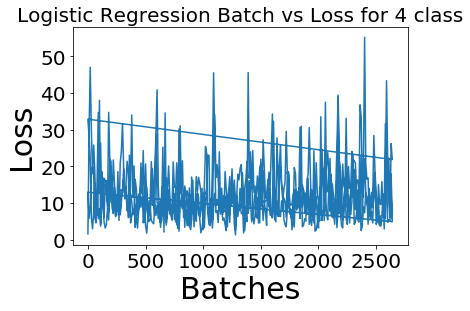

In [29]:
plt.plot(batch, loss)
plt.xlabel('Batches', fontsize = 30)
plt.ylabel('Loss', fontsize = 30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title("Logistic Regression Batch vs Loss for 4 class", fontsize = 20)
plt.show()

In [30]:
from torch.autograd import Variable
def to_one_hot(y, n_dims=None):
    """ Take integer y (tensor or variable) with n dims and convert it to 1-hot representation with n+1 dims. """
    y_tensor = y.data if isinstance(y, Variable) else y
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    y_one_hot = y_one_hot.view(*y.shape, -1)
    return Variable(y_one_hot) if isinstance(y, Variable) else y_one_hot

In [31]:
def computeAUROC (data, dataPRED, classCount):

    outAUROC = []

    datanpGT = data.numpy()
    datanpPRED = dataPRED.numpy()

    for i in range(classCount):
        try:
            outAUROC.append(roc_auc_score(datanpGT[:, i], datanpPRED[:, i]))
        except ValueError:
            pass
    return outAUROC


#-------------------------------------------------------------------------------- 


def test(model, dataLoaderTest, nnClassCount, class_names):   

   
    #outGT = torch.FloatTensor().cuda()
    #outPRED = torch.FloatTensor().cuda()
    
    outGT = torch.FloatTensor()
    outPRED = torch.FloatTensor()
    
    model.eval()

    with torch.no_grad():
        for image, label in dataLoaderTest:
            image = image.reshape(-1, 196608)
            target = to_one_hot(label, 4)
            outGT = torch.cat((outGT, target), 0)

            out = model(image)
            outPRED = torch.cat((outPRED, out), 0)
        
    aurocIndividual = computeAUROC(outGT, outPRED, nnClassCount)
    aurocMean = np.array(aurocIndividual).mean()

    print ('AUROC mean ', aurocMean)

    for i in range (0, len(aurocIndividual)):
        print (class_names[i], ' ', aurocIndividual[i])

    return outGT, outPRED

In [32]:
class_names = ["Pleural Effusion","Edema","Cardiomegaly","Pneumonia"]
outGT1, outPRED1 = test(model, validation_loader, 4, class_names)

AUROC mean  0.522946143004
Pleural Effusion   0.433333333333
Edema   0.446153846154
Cardiomegaly   0.591085271318
Pneumonia   0.621212121212


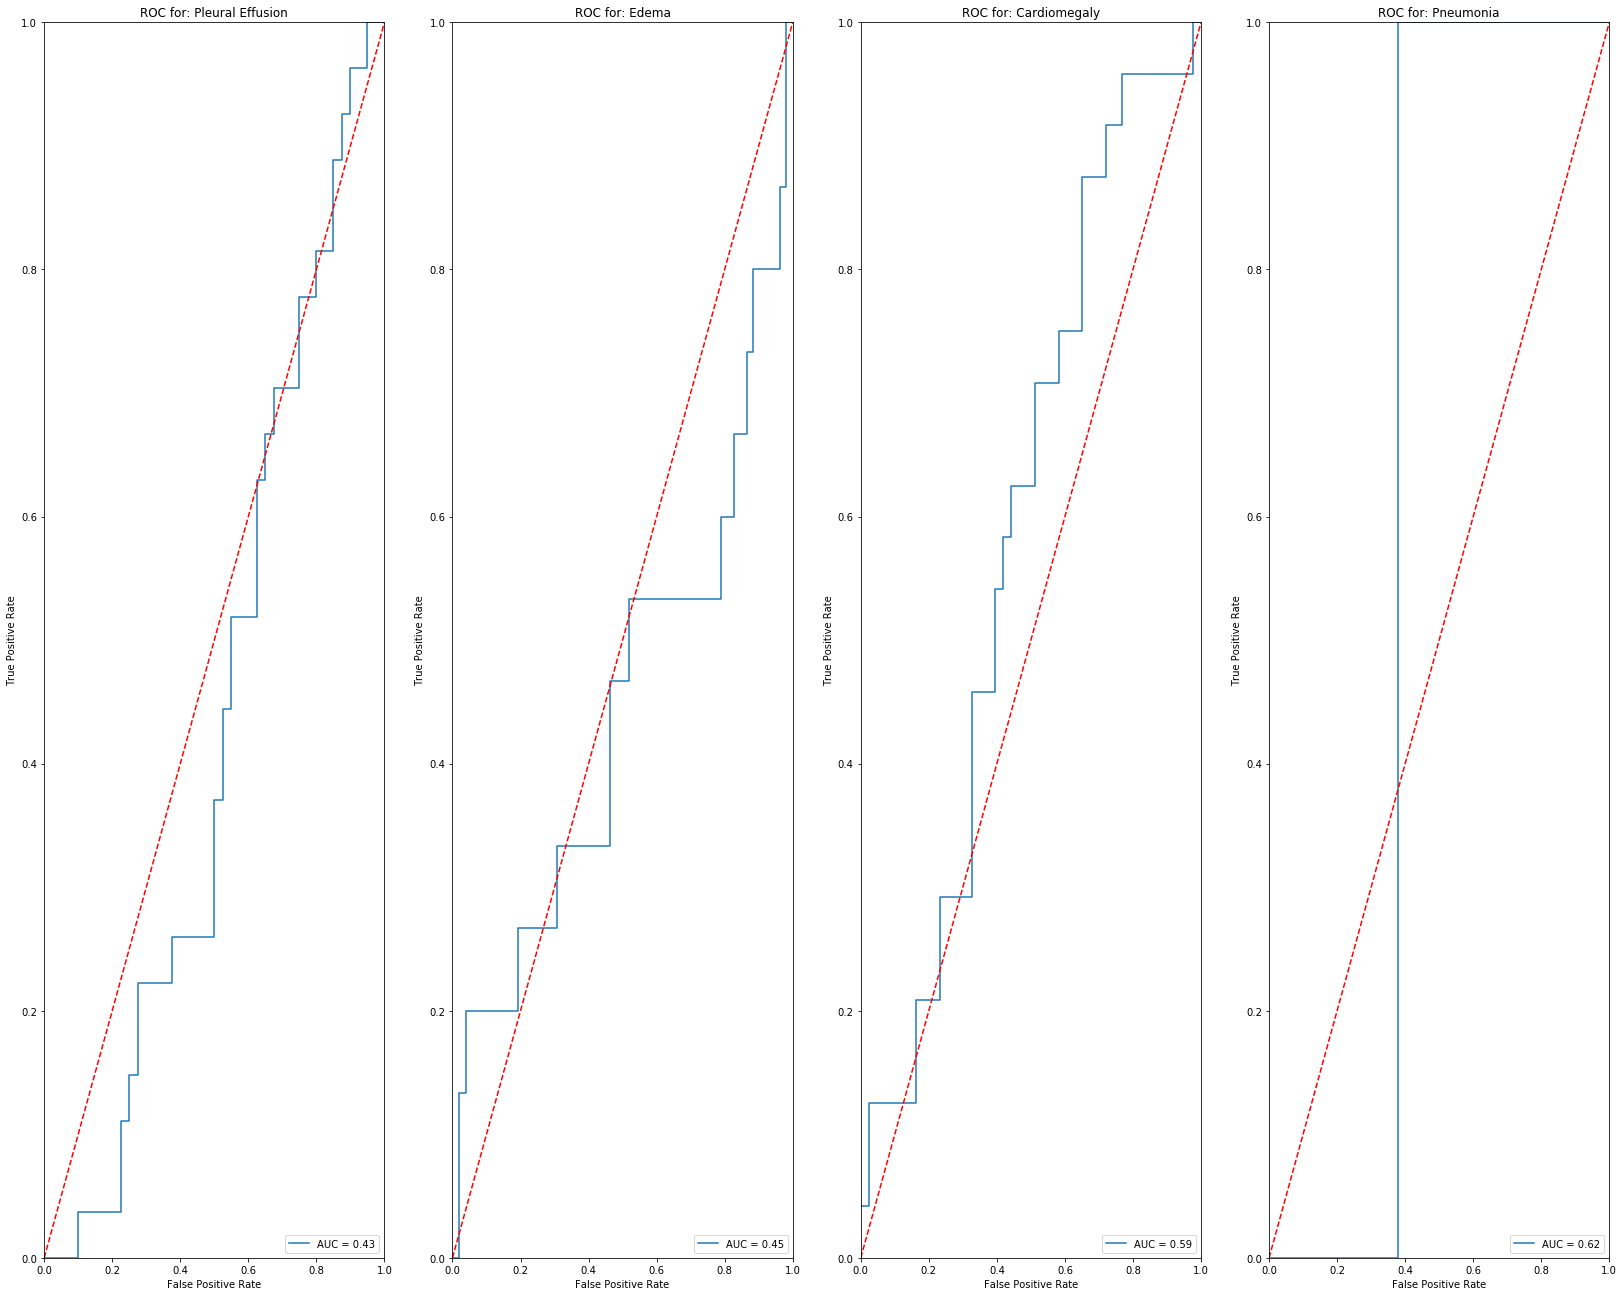

In [34]:
for i in range(4):
    fpr, tpr, threshold = metrics.roc_curve(outGT1[:,i], outPRED1[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    f = plt.subplot(2, 7, i+1)
    plt.title('ROC for: ' + class_names[i])
    plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
    
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 50
fig_size[1] = 50
plt.rcParams["figure.figsize"] = fig_size

#plt.savefig("ROC1345.png", dpi=1000)
plt.show()